In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
%matplotlib  widget 

In [3]:
j = 5; key1 = 'unfilt'; key2 = 'ref_pix'
dx = 4000
dy = 1100
# read in disp rate file + rmse file
fileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'.r4'
errorFileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'_residual_std.r4'
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/12_rate_inversions/disp_rate_maps_with_western_mtns/'
disp_rates = np.ndarray((dy,dx),dtype='float') 
disp_rates_errors = np.ndarray((dy,dx),dtype='float') 
f1 = gdal.Open(saveDir+fileName, gdal.GA_ReadOnly)
disp_rates = f1.ReadAsArray()
f1 = None
f1 = gdal.Open(saveDir+errorFileName, gdal.GA_ReadOnly)
disp_rates_errors = f1.ReadAsArray()
f1 = None
print('interval '+str(j)+' disp rate map + errors loaded.')

interval 5 disp rate map + errors loaded.


In [4]:
seismic2 = plt.cm.get_cmap("seismic").copy()
seismic2.set_bad(color='green')
print('colormap made where NANs will be green.')

colormap made where NANs will be green.


In [5]:
loadDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'

file_name = 'coh_avg.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
coh_avg = f1.ReadAsArray(); f1 = None
print('Avg coh values map loaded.')

file_name = 'coh_std.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
coh_std = f1.ReadAsArray(); f1 = None
print('Std of coh map loaded.')

file_name = 'amp_dispersion.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
amp_dispersion = f1.ReadAsArray(); f1 = None
print('Amplitude dispersion for each pixel loaded.')

file_name = 'avg_amp.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
avg_amp = f1.ReadAsArray(); f1 = None
print('Average amp for each pixel loaded.')

file_name = 'unfilt_unwrapped/wrap_err.i1' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
wrap_err = f1.ReadAsArray(); f1 = None
print('wrap errors for each pixel loaded.')

file_name = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/hpcor.r4' 
f1 = gdal.Open(file_name, gdal.GA_ReadOnly)
hp = f1.ReadAsArray(); f1 = None
# cropped area
x1 = 18000; x2 = 14000
y1 = 2100; y2 = 1000
hp_phs = hp[y2:y1,x2:x1]
print('high pass phase for each pixel loaded.')

Avg coh values map loaded.
Std of coh map loaded.
Amplitude dispersion for each pixel loaded.
Average amp for each pixel loaded.
wrap errors for each pixel loaded.
high pass phase for each pixel loaded.


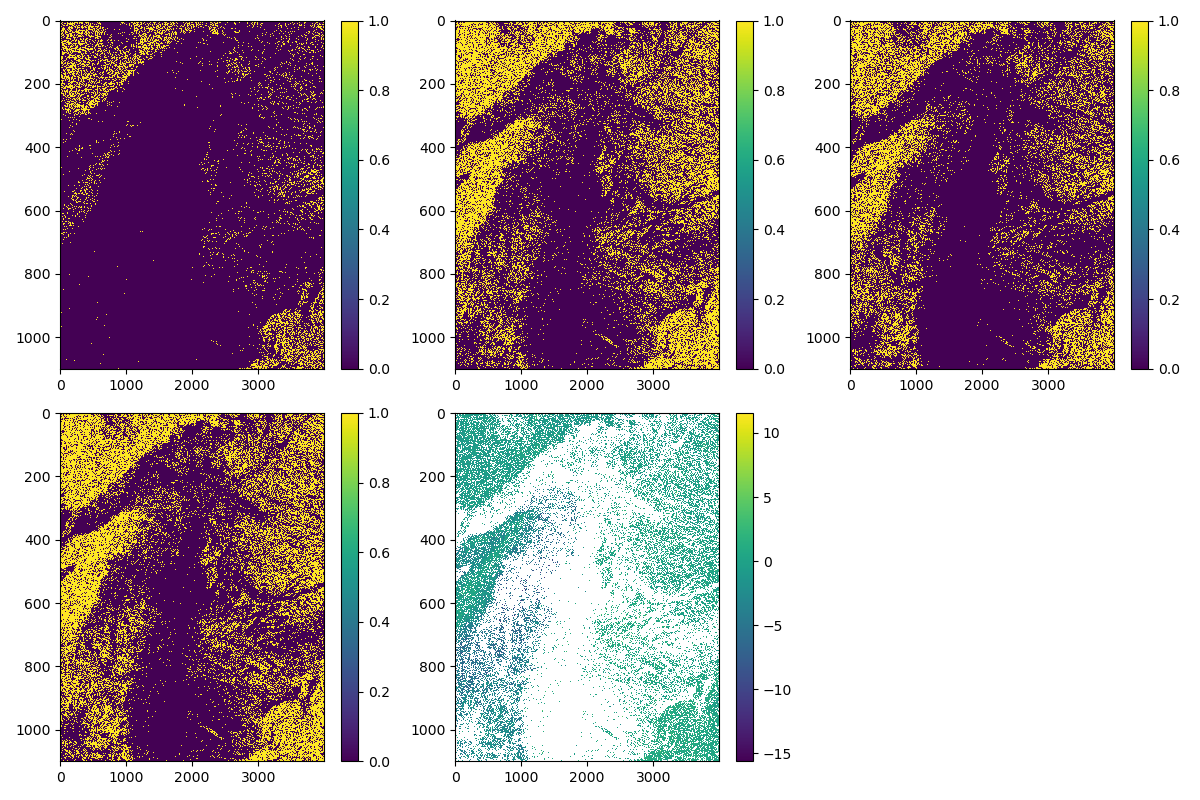

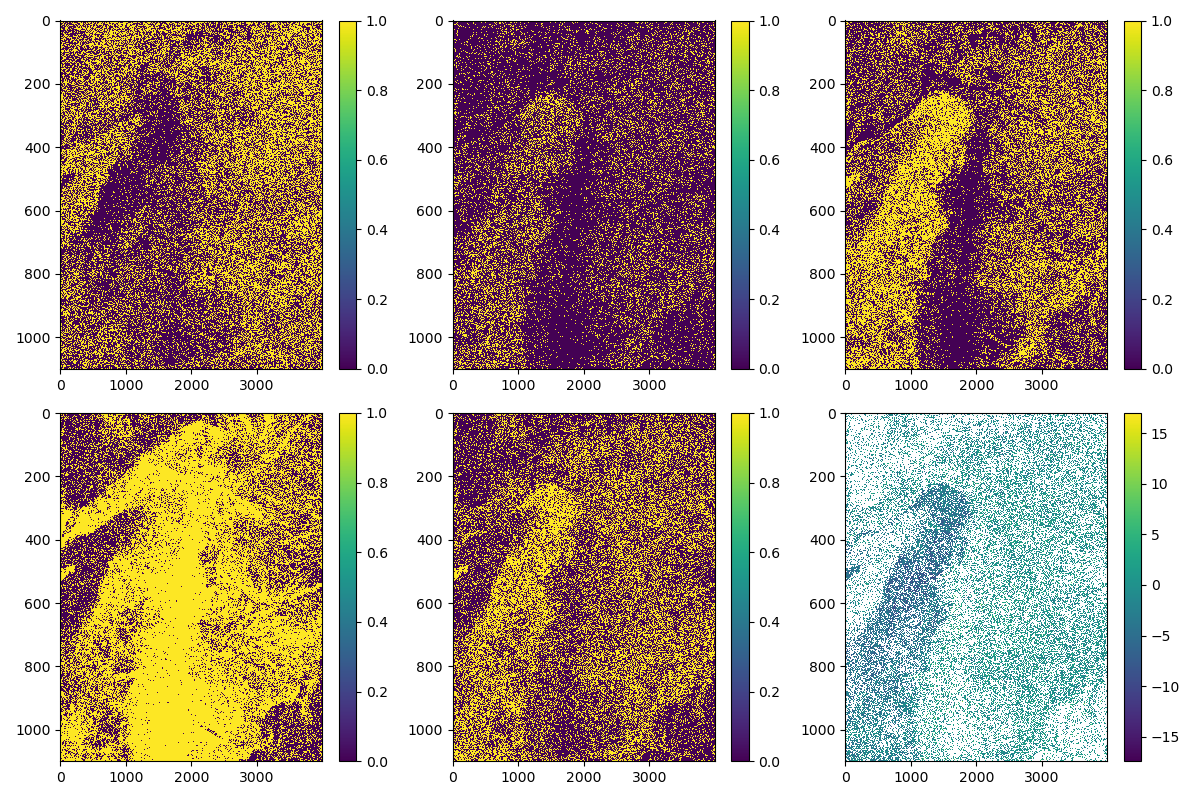

In [7]:
#   for reference: 
ad_best  = 0.35
ad_ok    = 0.5
we_best  = 5
we_ok    = 10
hp_best  = 0.8
hp_ok    = 0.6

# POPULATION 1
# boolean arrays 
ad_pop1_mask = (amp_dispersion<ad_best) 
we_pop1_mask = (wrap_err<we_best) 
hp_pop1_mask = (hp_phs>hp_best)
# by adding, essentially does "or" statement for all conditions. Still boolean array.
pop1_combo_mask = ad_pop1_mask + we_pop1_mask + hp_pop1_mask
# now mask disp rates based on where mask is True/False
pop1_combo = np.ma.masked_where(pop1_combo_mask==False,disp_rates)

# POPULATION 2
ad1_pop2_mask = (amp_dispersion>ad_best) 
ad2_pop2_mask = (amp_dispersion<ad_ok) 
we1_pop2_mask = (wrap_err>we_best) 
we2_pop2_mask = (wrap_err<we_ok) 
hp1_pop2_mask = (hp_phs<hp_best)
hp2_pop2_mask = (hp_phs>hp_ok)
pop2_last_mask = (pop1_combo_mask==False)
# by adding, essentially does "or" statement for all conditions. Still boolean array.
pop2_combo_mask = (ad1_pop2_mask*ad2_pop2_mask) + (we1_pop2_mask*we2_pop2_mask) + (hp1_pop2_mask*hp2_pop2_mask)
pop2_combo_mask = pop2_combo_mask * pop2_last_mask 
# now mask disp rates based where mask is False
pop2_combo = np.ma.masked_where(pop2_combo_mask==False,disp_rates)

# plot POP 1
plt.figure(figsize=(12,8),tight_layout=True)
plt.subplot(2,3,1)
plt.imshow(ad_pop1_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,2)
plt.imshow(we_pop1_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,3)
plt.imshow(hp_pop1_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,4)
plt.imshow(pop1_combo_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,5)
plt.imshow(pop1_combo,aspect='auto',interpolation='none'); plt.colorbar()
plt.show()

# plot POP 2
plt.figure(figsize=(12,8),tight_layout=True)
plt.subplot(2,3,1)
plt.imshow(ad1_pop2_mask*ad2_pop2_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,2)
plt.imshow(we1_pop2_mask*we2_pop2_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,3)
plt.imshow(hp1_pop2_mask*hp2_pop2_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,4)
plt.imshow(pop2_last_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,5)
plt.imshow(pop2_combo_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,6)
plt.imshow(pop2_combo,aspect='auto',interpolation='none'); plt.colorbar()
plt.show()

In [15]:
#def mask_smooth(masked_array,disp_rates,dy,dx):

masked_array = pop1_combo

mask_y,mask_x = np.nonzero(masked_array)    # find pix where values haven't been masked
mask = np.zeros((dy,dx))                    # initialize an array of zeros that's the same size as input for the mask
mask[mask_y,mask_x] = 1.0                   # put 1's in the spots that had real values 
#alooks = 4                                  # amount to filter in the azimuth/y direction
alooks = 4
#rlooks = 20                                 # amount to filter in the range/x direction
rlooks = 20 # TRY THIS 
mask_filt = gaussian_filter(mask,sigma=[alooks/2,rlooks/2])     # filter the mask to smear it out
Nans_y,Nans_x = np.where(mask_filt==0)      # find where the filtered mask didn't reach (which pix are still 0)
vels_masked = np.zeros((dy,dx))             # initialize array of zeros that's the same size as input for the velocities
vels_masked[mask_y,mask_x] = disp_rates[mask_y,mask_x]      # put in the "good" disp rates into the masked vels array.
vels_filt = gaussian_filter(vels_masked,sigma=[alooks/2,rlooks/2])  # filter the vels_masked 
# divide the two
ab = vels_filt / mask_filt    
#ab[mask_y,mask_x] = disp_rates[mask_y,mask_x]   # put back in the good values. OPTIONAL
ab[Nans_y,Nans_x] = np.nan                  # put Nans where the smoothed values didn't reach.

# calculate the std of the mean velocity 
residuals = masked_array-ab                 # removed on avg the mean, this is (value-mean) 
residuals2 = np.square(residuals)                   # (value-mean)^2
var_filt = gaussian_filter(residuals2,sigma=[alooks/2,rlooks/2])    # avg of the (value-mean)^2
var_ab = var_filt/mask_filt                 # divide by mask to not create edge effects that drop off to zero 
var_ab[Nans_y,Nans_x] = np.nan              # put Nans where the smoothed values didn't reach.

var_mean_ab = var_ab/mask_filt              # get the variance of the means, dividing by the density of pixels 
var_mean_ab[Nans_y,Nans_x] = np.nan         # put Nans back in where no values should be. 


#return ab, var_ab, var_mean_ab

/tmp/ipykernel_7124/4009694134.py:18: RuntimeWarning: invalid value encountered in true_divide
  ab = vels_filt / mask_filt
/tmp/ipykernel_7124/4009694134.py:26: RuntimeWarning: divide by zero encountered in true_divide
  var_ab = var_filt/mask_filt                 # divide by mask to not create edge effects that drop off to zero


In [17]:
# initialize array of Nans for each map.
num_pix_pop1 = np.zeros((dy,dx))*np.nan
num_pix_pop2 = np.zeros((dy,dx))*np.nan

# moving window size. Same as filter size from mask_smooth function.
#alooks = 4                                  # amount to filter in the azimuth/y direction
alooks = 4 # TRY THIS
ylooks = int(alooks/2)
#rlooks = 20                                 # amount to filter in the range/x direction
rlooks = 20                              
xlooks = int(rlooks/2)

# loop through pixels 
for y in range(dy):     #dy
    for x in range(dx): #dx
        # only if not an edge pixel
        if y-ylooks >= 0 and y+ylooks < dy and x-xlooks >= 0 and x+xlooks < dx:
            num_pix_pop1[y,x] = np.sum(pop1_combo_mask[y-ylooks:y+ylooks,x-xlooks:x+xlooks]) # pop1_combo_mask is 1's and 0's so it will add up how many pixels are in pop1 in that window.
            num_pix_pop2[y,x] = np.sum(pop2_combo_mask[y-ylooks:y+ylooks,x-xlooks:x+xlooks])
pix_density_pop1 = num_pix_pop1/(alooks*rlooks)
pix_density_pop2 = num_pix_pop2/(alooks*rlooks)

In [21]:
print(min(var_ab.flatten()))
print(min(var_mean_ab.flatten()))

0.43464980085598165
0.4884788791635002


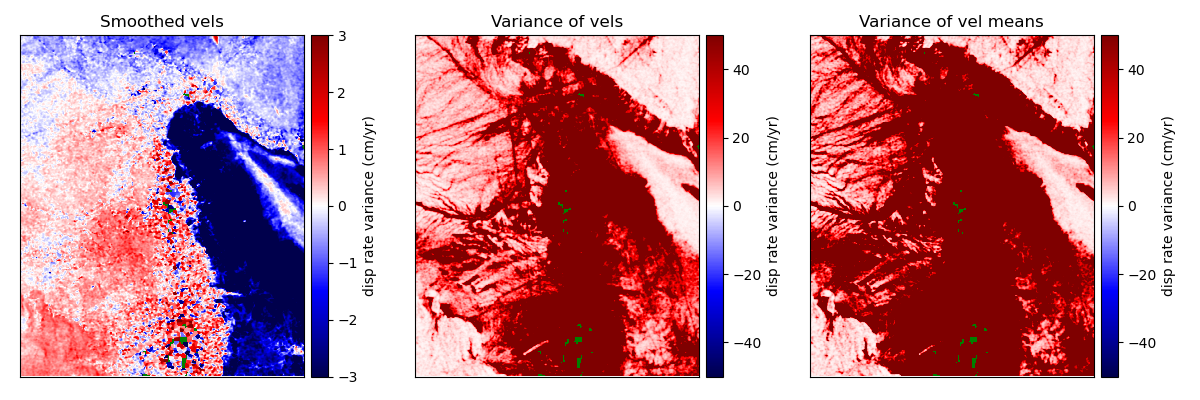

In [18]:
plt.figure(figsize=(12,4),tight_layout=True)
plt.subplot(1,3,1)
plt.imshow(ab, aspect='auto',interpolation='nearest',vmin=-3,vmax=3)
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate variance (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Smoothed vels')
plt.subplot(1,3,2)
plt.imshow(var_ab, aspect='auto', interpolation='nearest',vmin=-50,vmax=50)
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate variance (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Variance of vels')
plt.subplot(1,3,3)
plt.imshow(var_mean_ab, aspect='auto', interpolation='nearest',vmin=-50,vmax=50)
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate variance (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Variance of vel means')
plt.show()